# Segmentation

- During the last two notebooks we have encountered a complication in our dataset. The **image-level labelling** (or weak labelling).
- We have many cells of different varieties present in single images. This competition is a localisation and classification challenge, so we will be using the [HPA-Cell-Segmentation](https://github.com/CellProfiling/HPA-Cell-Segmentation) tool to segment our images, then classifying them with a vision model. 
- Images are also weakly labelled, only rough image-level labels included in the training set to train a cell-level classifier which presents an additional challenge. 

I will be following closely to [this kaggle notebook](https://www.kaggle.com/ayuraj/hpa-segmentation-mask-visualization-with-w-b) as a guide to using the segmentation tool.

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
#GPU count and name
!nvidia-smi -L

GPU 0: GeForce GTX 970 (UUID: GPU-fa9c9266-bf91-80d3-02fb-e1c62bb66c85)


In [4]:
# Find example images
import glob

IMG_DIR = '../input/'
red_images = sorted(glob.glob(IMG_DIR+'label_examples/*_red.png'))
green_images = sorted(glob.glob(IMG_DIR+'label_examples/*_green.png'))
blue_images = sorted(glob.glob(IMG_DIR+'label_examples/*_blue.png'))
yellow_images = sorted(glob.glob(IMG_DIR+'label_examples/*_yellow.png'))

print(len(red_images), len(green_images), len(blue_images), len(yellow_images))

5 5 5 5


In [5]:
id_s = [red_images[i].split('_red')[0].split('\\')[1].strip()\
        for i in range(len(red_images))]
id_s

['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
 'a34d8680-bb99-11e8-b2b9-ac1f6b6435d0',
 'a7faf0b4-bb99-11e8-b2b9-ac1f6b6435d0',
 'b6a469d8-bbad-11e8-b2ba-ac1f6b6435d0',
 'f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0']

In [6]:
import pandas as pd
# Find example rows from train.csv
train_csv = pd.read_csv(IMG_DIR + 'train.csv')
df = train_csv[train_csv.ID.isin(id_s)].reset_index(drop=True)
df

,ID,Label
0,a34d8680-bb99-11e8-b2b9-ac1f6b6435d0,18
1,a7faf0b4-bb99-11e8-b2b9-ac1f6b6435d0,17
2,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,15
3,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7|1|2|0
4,b6a469d8-bbad-11e8-b2ba-ac1f6b6435d0,11


In [7]:
# Column mapping for organelles
label_map = {
    '0': 'Nucleoplasm',
    '1': 'Nuclear membrane',
    '2': 'Nucleoli',
    '3': 'Nucleoli fibrillar center',
    '4': 'Nuclear speckles',
    '5': 'Nuclear bodies',
    '6': 'Endoplasmic reticulum',
    '7': 'Golgi apparatus',
    '8': 'Intermediate filaments',
    '9': 'Actin filaments',
    '10': 'Microtubules',
    '11': 'Mitotic spindle',
    '12': 'Centrosome',
    '13': 'Plasma membrane',
    '14': 'Mitochondria',
    '15': 'Aggresome',
    '16': 'Cytosol',
    '17': 'Vesicles and punctate cytosolic patterns',
    '18': 'Negative'
}

## HPA segmenation tool
From https://github.com/CellProfiling/HPA-Cell-Segmentation

!pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip --user

Run the above into your env. I have included it into the conda enviroment. So I won't run this in the notebook.

In [8]:
# assigning bio style variables to images
mt = red_images # microtubules
er = yellow_images # endoplasmic reticulum
nu = blue_images # nucleus 
pr = green_images # [proteins]
images = [mt, er, nu]

In [9]:
# HPA
import os
import imageio
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
NUC_MODEL = "./nuclei-model.pth"
CELL_MODEL = "./cell-model.pth"

segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cuda",
    padding=False,
    multi_channel_model=True,
)

# For nuclei
nuc_segmentations = segmentator.pred_nuclei(images[2])

# For full cells
cell_segmentations = segmentator.pred_cells(images)

# post-processing
for i, pred in enumerate(cell_segmentations):
    nuclei_mask, cell_mask = label_cell(nuc_segmentations[i], cell_segmentations[i])
    FOVname = os.path.basename(mt[i]).replace('red','predictedmask')
    imageio.imwrite('../input/label_examples/'+ FOVname, cell_mask) 

please compile abn


C:\Users\Admin\miniconda3\envs\cell\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Admin\miniconda3\envs\cell\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Admin\miniconda3\envs\cell\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by a

## Some pretty pictures of the U-Net segmentator in action...

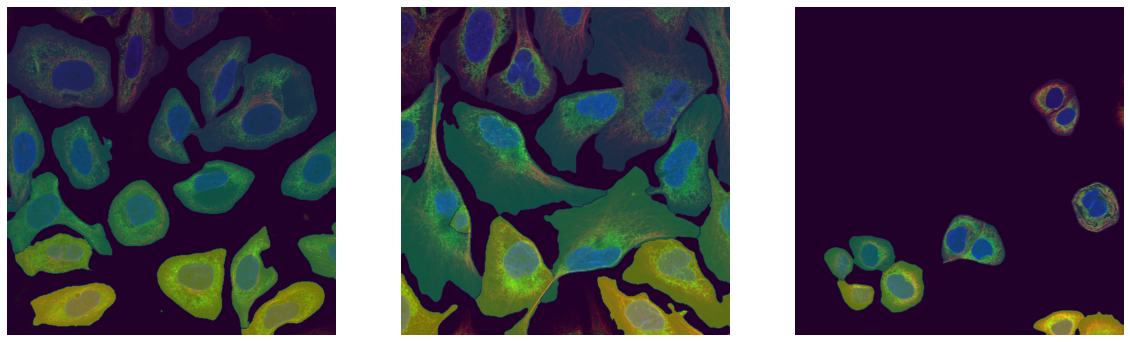

In [13]:
# Visualizing the segmentation masks we just predicted above
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(30,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    endoplasmicrec = plt.imread(er[i])    
    nuclei = plt.imread(nu[i])
    mask = plt.imread(mt[i].replace('red','predictedmask'))
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    ax[i].imshow(img)
    ax[i].imshow(mask, alpha=0.5)
    ax[i].axis('off')
plt.show()